In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns
import random
import ast
from numpy.polynomial.polynomial import Polynomial
import plotly.graph_objects as go
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

In [2]:
df = pd.read_csv('df_raw.csv')
df

,timestamp,description,transaction_type,transaction_category,transaction_classification,merchant_name,amount,currency,transaction_id,provider_transaction_id,normalised_provider_transaction_id,running_balance,meta,category
0,2023-05-15T00:00:00Z,ASDA STOES LTD,DEBIT,PURCHASE,"['Shopping', 'Groceries']",Asda Store,-32.00,GBP,7df25b8b363b330ff0fbd00e7d1889b0,2407673ec411138ad3,txn-e72056ea71aec1a15,"{'currency': 'GBP', 'amount': 385.53}",{'provider_transaction_category': 'DEB'},groceries / food spend
1,2023-05-15T00:00:00Z,SAVE THE CHANGE,DEBIT,BILL_PAYMENT,[],NaN,-0.55,GBP,6837f0c14f05143aaed1d44c7276c271,b14ef0725da52f48c9,txn-fa8edc6060dc16550,"{'currency': 'GBP', 'amount': 384.98}",{'provider_transaction_category': 'BP'},savings
2,2023-05-15T00:00:00Z,AMAZON BLACK FRIDAY,DEBIT,PURCHASE,[],NaN,-15.45,GBP,4a98cea75e4701e20fe09b5f34275f33,a916fe049fb714f4f2,txn-3344691261a1fd852,"{'currency': 'GBP', 'amount': 369.53}",{'provider_transaction_category': 'DEB'},shopping
3,2023-05-15T00:00:00Z,SAVE THE CHANGE,DEBIT,BILL_PAYMENT,[],NaN,-0.50,GBP,3daf9e4422d6744dffab6e46c0047819,c5a3da43b75042042e,txn-a493545c286d22ef5,"{'currency': 'GBP', 'amount': 369.03}",{'provider_transaction_category': 'BP'},savings
4,2023-05-15T00:00:00Z,TESCO EXTRA,DEBIT,PURCHASE,[],NaN,-3.59,GBP,c4d43871d491337ea788f664bb3ddcad,8c2564380aa4b45276,txn-710c77f63b5556e80,"{'currency': 'GBP', 'amount': 365.44}",{'provider_transaction_category': 'DEB'},shopping
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8875,2018-05-17T00:00:00Z,AA INSURANCE,DEBIT,DIRECT_DEBIT,"['Auto & Transport', 'Auto Insurance']",Axa,-12.73,GBP,94fdfafb2a3c85ff103b1d388f8634d3,2e742fc18e2dd660b3,txn-c103e8b5d0c141e3a,"{'currency': 'GBP', 'amount': 484.53}",{'provider_transaction_category': 'DD'},finances
8876,2018-05-17T00:00:00Z,AXA WEALTH LTD,DEBIT,DIRECT_DEBIT,[],NaN,-40.00,GBP,c15a3d1651b37d8ae9c24caf3b0620de,d3c9d8b8c5e79ae489,txn-055c16c58c21c741c,"{'currency': 'GBP', 'amount': 444.53}",{'provider_transaction_category': 'DD'},finances
8877,2018-05-17T00:00:00Z,MORRISONS PETROL,DEBIT,PURCHASE,"['Shopping', 'Groceries']",WM Morrisons,-20.00,GBP,d0bd0ad1ae4e56624197d39fb5410ca2,13a739579695636b0e,txn-ceb278bda7b734723,"{'currency': 'GBP', 'amount': 424.53}",{'provider_transaction_category': 'DEB'},transport
8878,2018-05-17T00:00:00Z,SAVE THE CHANGE,DEBIT,BILL_PAYMENT,[],NaN,-0.63,GBP,87130d2b2326d3356a67f449020645e4,fca47e9d876e55c228,txn-d0477dc1be8123d49,"{'currency': 'GBP', 'amount': 423.9}",{'provider_transaction_category': 'BP'},savings


# Cleaning and Processing

In [3]:
# Make sure column 'timestamp' is datetime data type
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['month_year'] = df['timestamp'].dt.to_period('M')

<ipython-input-3-188e43a5d19f>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month_year'] = df['timestamp'].dt.to_period('M')


In [4]:
# Remove columns of no use
columns_to_remove = ['transaction_id','provider_transaction_id','normalised_provider_transaction_id','transaction_classification', 'meta']
df = df.drop(columns=columns_to_remove)

In [5]:
df = df.iloc[:-1]

# Extract the valuable information from dictionary column '
df['running_balance'] = df['running_balance'].str.extract(r'"amount":\s(\d+\.\d+)', expand=False).fillna(df['running_balance'])
df['running_balance'] = df['running_balance'].apply(lambda x: ast.literal_eval(x)['amount'])


df

,timestamp,description,transaction_type,transaction_category,merchant_name,amount,currency,running_balance,category,month_year
0,2023-05-15 00:00:00+00:00,ASDA STOES LTD,DEBIT,PURCHASE,Asda Store,-32.00,GBP,385.53,groceries / food spend,2023-05
1,2023-05-15 00:00:00+00:00,SAVE THE CHANGE,DEBIT,BILL_PAYMENT,NaN,-0.55,GBP,384.98,savings,2023-05
2,2023-05-15 00:00:00+00:00,AMAZON BLACK FRIDAY,DEBIT,PURCHASE,NaN,-15.45,GBP,369.53,shopping,2023-05
3,2023-05-15 00:00:00+00:00,SAVE THE CHANGE,DEBIT,BILL_PAYMENT,NaN,-0.50,GBP,369.03,savings,2023-05
4,2023-05-15 00:00:00+00:00,TESCO EXTRA,DEBIT,PURCHASE,NaN,-3.59,GBP,365.44,shopping,2023-05
...,...,...,...,...,...,...,...,...,...,...
8874,2018-05-17 00:00:00+00:00,MR JOHN SMITH,CREDIT,CREDIT,NaN,137.60,GBP,497.26,transfer,2018-05
8875,2018-05-17 00:00:00+00:00,AA INSURANCE,DEBIT,DIRECT_DEBIT,Axa,-12.73,GBP,484.53,finances,2018-05
8876,2018-05-17 00:00:00+00:00,AXA WEALTH LTD,DEBIT,DIRECT_DEBIT,NaN,-40.00,GBP,444.53,finances,2018-05
8877,2018-05-17 00:00:00+00:00,MORRISONS PETROL,DEBIT,PURCHASE,WM Morrisons,-20.00,GBP,424.53,transport,2018-05


In [6]:
# Adding randomness to dataset by varing amount spend each category based on intuition

category_variation = {
    'groceries / food spend': 0.8,  # This can fluctuate greatly depending on the day, week, etc.
    'savings': 0.1,  # Normally this would not vary too much as it's typically a fixed amount each month.
    'shopping': 0.8,  # This could greatly depend on the person's habits.
    'entertainment': 0.8,  # Could vary greatly as it's not a necessary expense.
    'transport': 0.3,  # This would likely be fairly constant, unless there's a vacation or special event.
    'finances': 0.2,  # Investments, insurance payments etc. are usually quite steady.
    'transfer': 0.5,  # Transfers could vary depending on needs.
    'taxes': 0.05,  # Taxes are usually fairly predictable and constant.
    'holidays': 1.0,  # Could vary greatly, from no spending to very high amounts.
    'bills and utilities': 0.1,  # These are typically fairly constant, but could vary with seasons.
    'fees and charges': 0.5,  # Could depend on specific transactions, late fees, etc.
    'rent': 0.0,  # Rent is usually a constant amount.
    'home and garden': 0.6,  # Could vary depending on home needs/improvements.
    'business services': 0.4,  # Could vary based on business needs.
    'restaurants / eating out / delivery': 0.7,  # This could greatly vary depending on habits/social events.
    'salary': 0.0  # Salary is typically a constant amount.
}

# Applying the variations
for category in df['category'].unique():
    mask = df['category'] == category  # Filter for the current category
    variation = category_variation[category]  # Get the variation for the current category

    # Determine which rows to randomize
    num_rows = df[mask].shape[0]
    randomize = np.random.choice([True, False], size=num_rows, p=[0.5, 0.5])

    random_percentage = 1 + np.random.normal(loc=0, scale=variation, size=num_rows)  # Generate random percentages
    random_percentage = np.where(randomize, random_percentage, 1)  # Only randomize 50% of the data

    df.loc[mask, 'amount'] = df.loc[mask, 'amount'] * random_percentage  # Apply the randomness to 'amount'




# Adding randomness to dataset by varing frequency of each category based on intuition
category_frequency_variation = {
    'groceries / food spend': 0.3,
    'savings': 0.1,
    'shopping': 0.5,
    'entertainment': 0.6,
    'transport': 0.2,
    'finances': 0.2,
    'transfer': 0.3,
    'taxes': 0.2,
    'holidays': 0.7,
    'bills and utilities': 0.0,
    'fees and charges': 0.3,
    'rent': 0.0,
    'home and garden': 0.5,
    'business services': 0.3,
    'restaurants / eating out / delivery': 0.6,
    'salary': 0.0
}



df_varied = df.copy()

for category in df['category'].unique():
    mask = df['category'] == category  # Filter for the current category
    variation = category_frequency_variation[category]  # Get the variation for the current category

    # Determine which rows to remove
    remove_mask = [random.random() < variation for _ in range(sum(mask))]

    # Remove the selected rows
    df_varied = df_varied.drop(df[mask][remove_mask].index)

# Reset the index
df_varied = df_varied.reset_index(drop=True)


In [7]:
# Round to two decimal places
df['amount'] = df['amount'].round(2)
# Set all running balances except for the last row to 0
df.iloc[:-1, df.columns.get_loc('running_balance')] = 0

# Calculate the running balance from the last row to the top row
for index in range(len(df)-1, 0, -1):
    df.at[index-1, 'running_balance'] = np.round(df.at[index, 'running_balance'] + df.at[index, 'amount'], 2)

In [8]:
# Filter the DataFrame, shorten the time period in order to see the more detailed visualisation
start_date = '2022-01'
end_date = '2023-02'
df = df[(df['month_year'] >= start_date) & (df['month_year'] <= end_date)]


In [9]:
# List of columns to keep
columns_to_keep = ['timestamp', 'amount', 'running_balance', 'month_year', 'category']

# Create a new DataFrame with only the selected columns
df_predict = df[columns_to_keep]

# Export the new DataFrame to a CSV file
df_predict.to_csv('df_predict.csv', index=False)

# Visual analysis

<ipython-input-10-c6592d9af43a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])


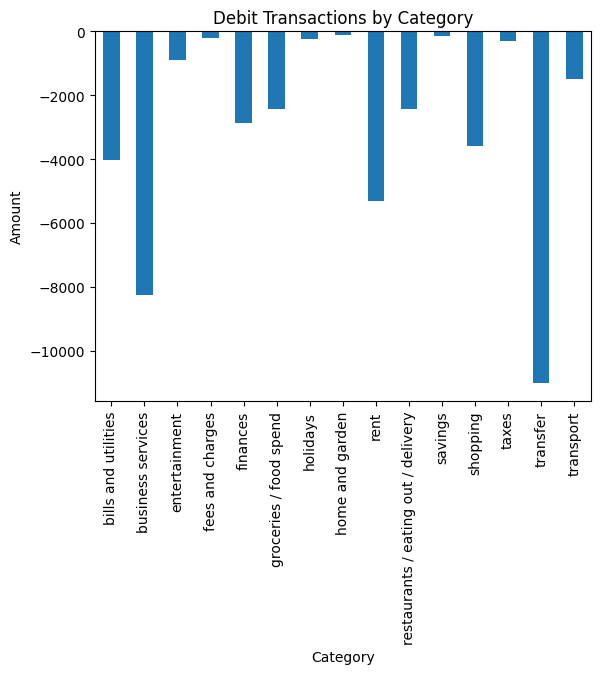

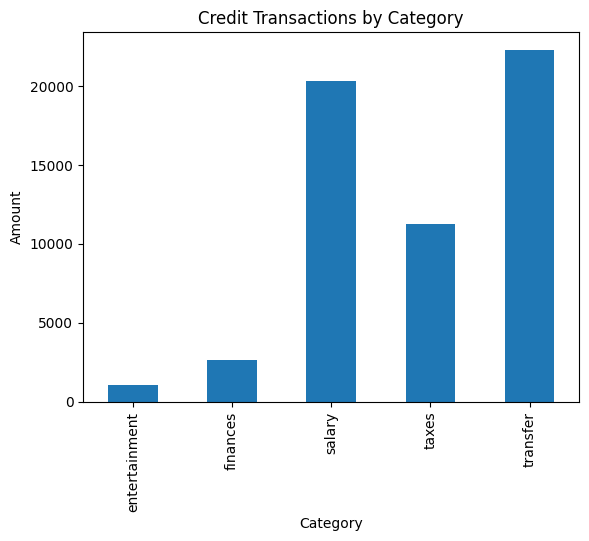

In [10]:
# ensure timestamp is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# separate debit and credit transactions
df_debit = df[df['transaction_type'] == 'DEBIT']
df_credit = df[df['transaction_type'] == 'CREDIT']

# group by category and sum the amount for debit transactions
debit_by_category = df_debit.groupby('category')['amount'].sum()

# plot the debit transactions by category
debit_by_category.plot(kind='bar')
plt.title('Debit Transactions by Category')
plt.xlabel('Category')
plt.ylabel('Amount')
plt.show()

# similarly for credit transactions
credit_by_category = df_credit.groupby('category')['amount'].sum()

credit_by_category.plot(kind='bar')
plt.title('Credit Transactions by Category')
plt.xlabel('Category')
plt.ylabel('Amount')
plt.show()

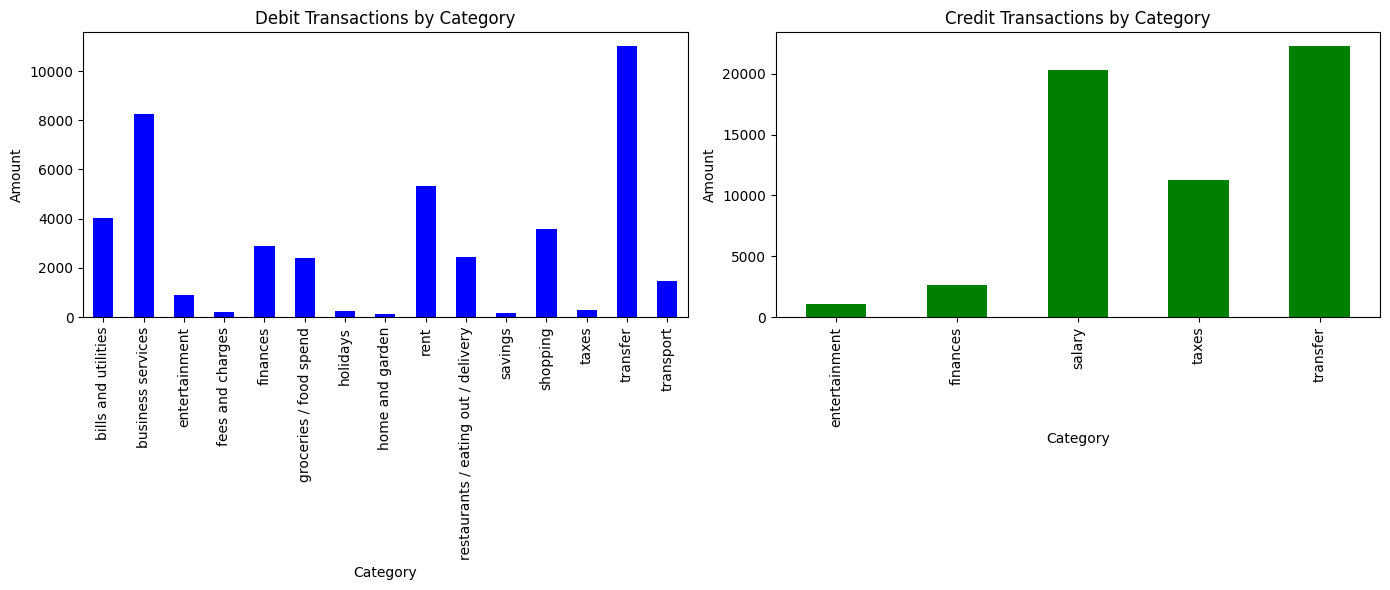

In [11]:
# group by category and sum the amount for debit transactions
# then multiply by -1 to make them positive
debit_by_category = df_debit.groupby('category')['amount'].sum() * -1

# group by category and sum the amount for credit transactions
credit_by_category = df_credit.groupby('category')['amount'].sum()

# create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# plot debit transactions by category
debit_by_category.plot(kind='bar', ax=axs[0], color='blue')
axs[0].set_title('Debit Transactions by Category')
axs[0].set_xlabel('Category')
axs[0].set_ylabel('Amount')

# plot credit transactions by category
credit_by_category.plot(kind='bar', ax=axs[1], color='green')
axs[1].set_title('Credit Transactions by Category')
axs[1].set_xlabel('Category')
axs[1].set_ylabel('Amount')

# display the plots
plt.tight_layout()
plt.show()


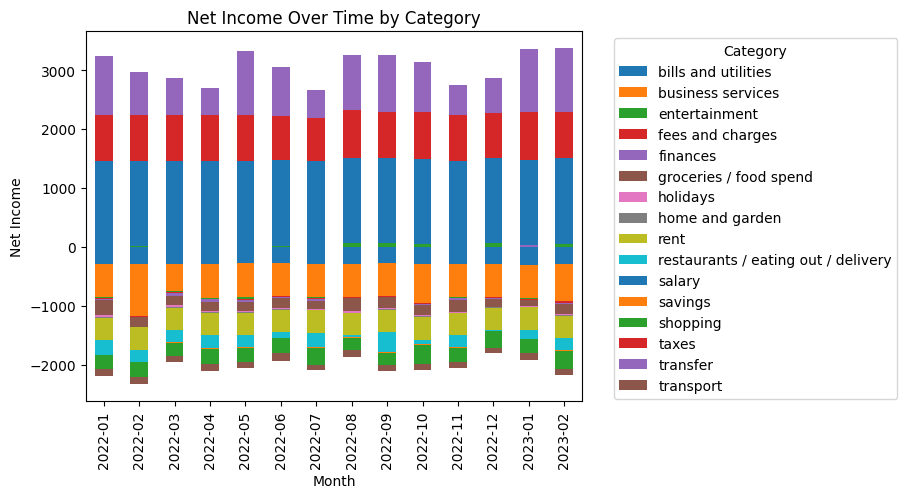

In [12]:
# Group by 'month_year' and 'category' and sum 'amount'
net_income_by_month = df.groupby(['month_year', 'category'])['amount'].sum().unstack()

# Plot a stacked bar chart
net_income_by_month.plot(kind='bar', stacked=True)
plt.title('Net Income Over Time by Category')
plt.xlabel('Month')
plt.ylabel('Net Income')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


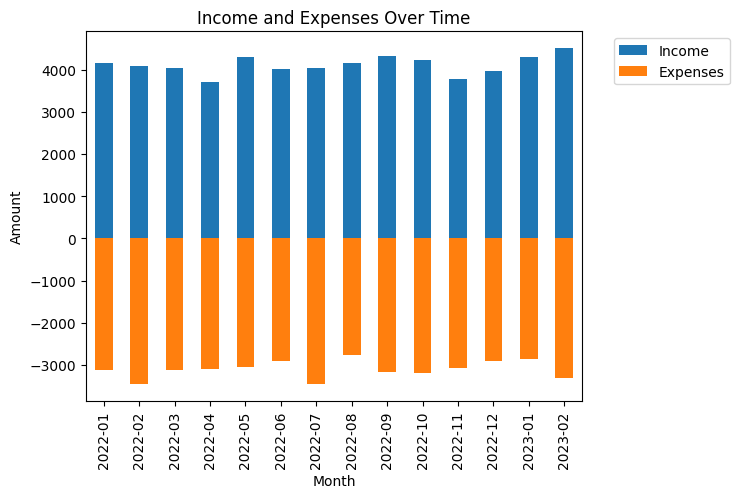

In [13]:
# Separate income and expenses
df_income = df[df['amount'] > 0]
df_expenses = df[df['amount'] < 0]

# Group by 'month_year' and sum 'amount' for income and expenses
income_by_month = df_income.groupby(['month_year'])['amount'].sum()
expenses_by_month = df_expenses.groupby(['month_year'])['amount'].sum()

# Combine income and expenses into one DataFrame
df_plot = pd.DataFrame({'Income': income_by_month, 'Expenses': expenses_by_month})

# Plot a stacked bar chart
df_plot.plot(kind='bar', stacked=True)
plt.title('Income and Expenses Over Time')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


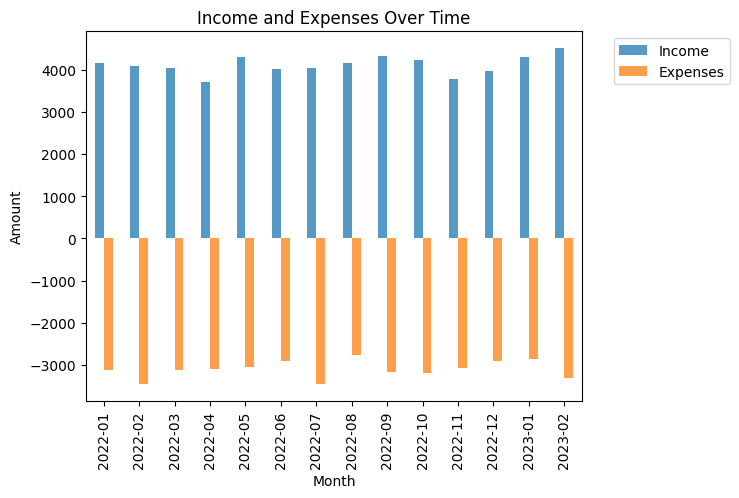

In [14]:
# Combine income and expenses into one DataFrame
df_plot = pd.DataFrame({'Income': income_by_month, 'Expenses': expenses_by_month})

# Plot a grouped bar chart
df_plot.plot(kind='bar', alpha=0.75)
plt.title('Income and Expenses Over Time')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


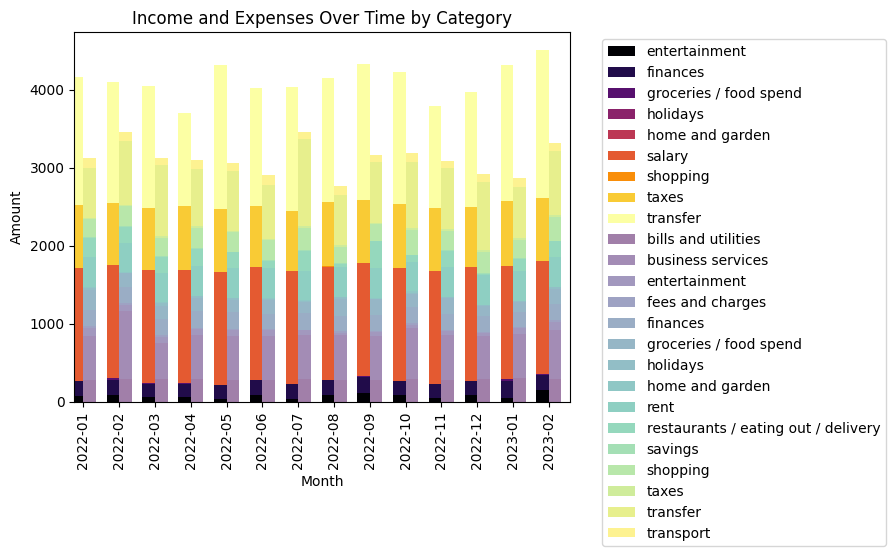

In [15]:
# Group by 'month_year' and 'category' and sum 'amount' for income and expenses
income_by_month_category = df_income.groupby(['month_year', 'category'])['amount'].sum()
expenses_by_month_category = df_expenses.groupby(['month_year', 'category'])['amount'].sum().abs()

# take absolute value # Reset index to flatten the dataframes
income_by_month_category = income_by_month_category.reset_index()
expenses_by_month_category = expenses_by_month_category.reset_index()

# Pivot the dataframes to have categories as columns
income_pivot = income_by_month_category.pivot(index='month_year', columns='category', values='amount')
expenses_pivot = expenses_by_month_category.pivot(index='month_year', columns='category', values='amount')

# Create subplots
fig, ax = plt.subplots()

# Plot income and expenses side by side with different colors for each category
width = 0.35  # width of the bars
income_pivot.plot(kind='bar', stacked=True, position=1, width=width, ax=ax, colormap='inferno')
expenses_pivot.plot(kind='bar', stacked=True, position=0, width=width, ax=ax, colormap='viridis', alpha=0.5)

# Set labels
ax.set_xlabel('Month')
ax.set_ylabel('Amount')
ax.set_title('Income and Expenses Over Time by Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


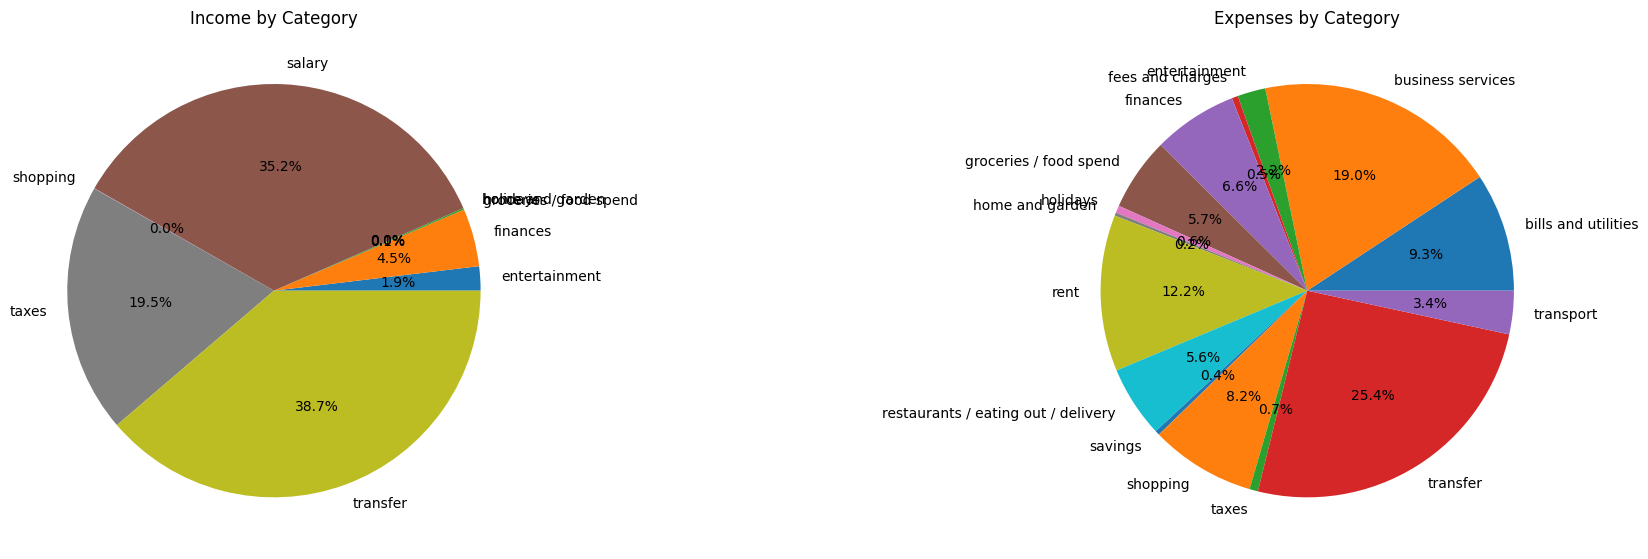

In [16]:
# Group by 'category' and sum 'amount' for income and expenses
income_by_category = df_income.groupby(['category'])['amount'].sum()
expenses_by_category = df_expenses.groupby(['category'])['amount'].sum().abs() # take absolute value for expenses
# Plot pie charts
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
plt.subplots_adjust(wspace=1)

income_by_category.plot(kind='pie', ax=ax[0], autopct='%1.1f%%')
ax[0].set_ylabel('')  # This removes the 'amount' ylabel.
ax[0].set_title('Income by Category')

expenses_by_category.plot(kind='pie', ax=ax[1], autopct='%1.1f%%')
ax[1].set_ylabel('')  # This removes the 'amount' ylabel.
ax[1].set_title('Expenses by Category')

plt.show()


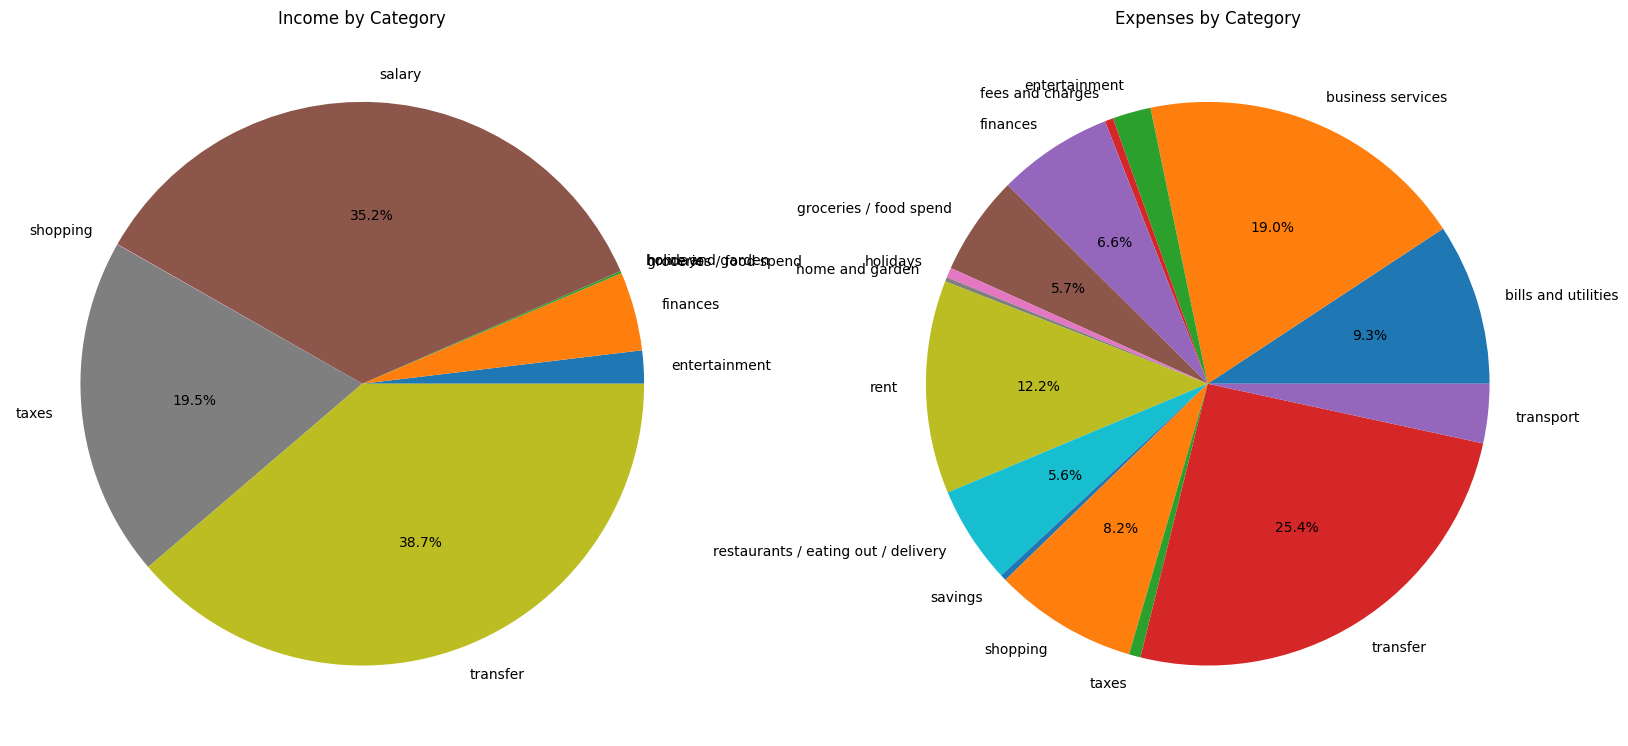

In [17]:
# Define a function for autopct
def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 5 else ''

# Plot pie charts
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

income_by_category.plot(kind='pie', ax=ax[0], autopct=my_autopct)
ax[0].set_ylabel('')  # This removes the 'amount' ylabel.
ax[0].set_title('Income by Category')

expenses_by_category.plot(kind='pie', ax=ax[1], autopct=my_autopct)
ax[1].set_ylabel('')  # This removes the 'amount' ylabel.
ax[1].set_title('Expenses by Category')

plt.show()


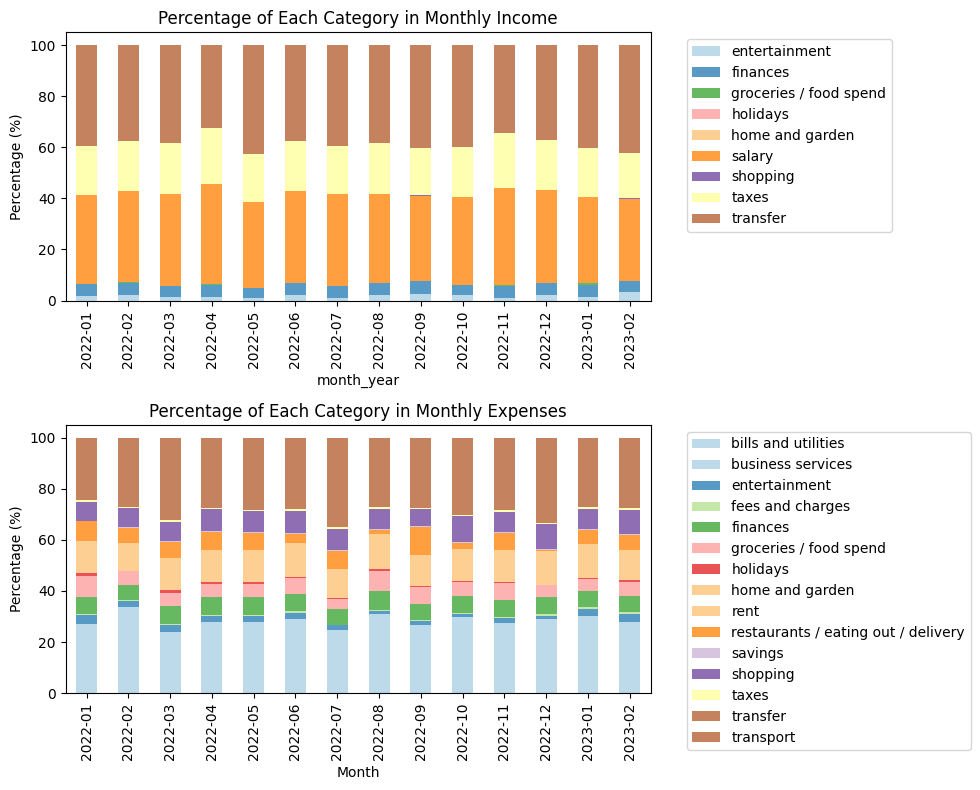

In [18]:
# Grouping the income dataframe by month_year and calculating the total amount for each month
total_monthly_income = df_income.groupby(['month_year'])['amount'].sum()

# Grouping the expenses dataframe by month_year and calculating the total amount for each month. Absolute values are used as expenses may be negative values.
total_monthly_expenses = df_expenses.groupby(['month_year'])['amount'].sum().abs()

# Grouping the income dataframe by month_year and category, then unstacking the categories to create a dataframe with categories as columns and their amounts as the values
income_by_category_month = df_income.groupby(['month_year', 'category'])['amount'].sum().unstack()

# Similar operation for the expenses dataframe
expenses_by_category_month = df_expenses.groupby(['month_year', 'category'])['amount'].sum().abs().unstack()

# Calculating the percentage of each category's contribution to the total monthly income
income_percentage = income_by_category_month.divide(total_monthly_income, axis=0) * 100

# Calculating the percentage of each category's contribution to the total monthly expenses
expenses_percentage = expenses_by_category_month.divide(total_monthly_expenses, axis=0) * 100

# Creating subplots to plot both income and expense percentages
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plotting the income percentages as a stacked bar chart
income_percentage.plot(kind='bar', stacked=True, ax=ax[0], alpha=0.75, colormap='Paired')
ax[0].set_title('Percentage of Each Category in Monthly Income')
ax[0].set_ylabel('Percentage (%)')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plotting the expenses percentages as a stacked bar chart
expenses_percentage.plot(kind='bar', stacked=True, ax=ax[1], alpha=0.75, colormap='Paired')
ax[1].set_title('Percentage of Each Category in Monthly Expenses')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Percentage (%)')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjusting the layout to ensure everything fits properly
plt.tight_layout()

# Displaying the plots
plt.show()


# Trends and seasonality analysis

<ipython-input-19-af5d78cdffc0>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month_year'] = df['timestamp'].dt.to_period('M')
<ipython-input-19-af5d78cdffc0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_year'] = df['timestamp'].dt.to_period('M')
<ipython-input-19-af5d78cdffc0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['running_balance'] = pd.to_numeric(df['running_balance'], errors='coerce')


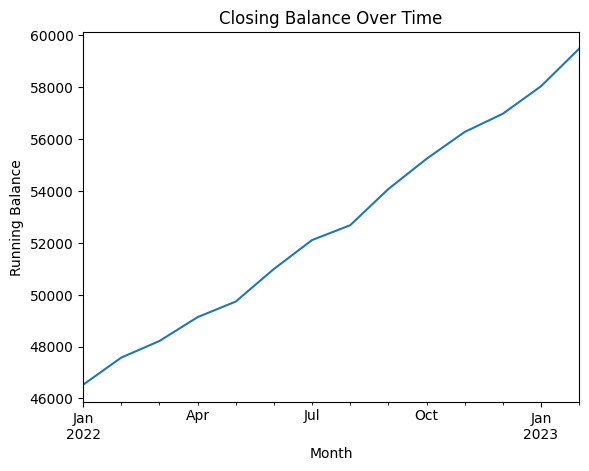

In [19]:
# Convert 'timestamp' to datetime and extract the year-month
df['month_year'] = df['timestamp'].dt.to_period('M')
df['running_balance'] = pd.to_numeric(df['running_balance'], errors='coerce')

# Group by 'month_year' and get the last 'runningBalance' for each month
running_balance_by_month = df.groupby('month_year')['running_balance'].last()

# Plot the time series
running_balance_by_month.plot(kind='line')
plt.title('Closing Balance Over Time')
plt.xlabel('Month')
plt.ylabel('Running Balance')
plt.show()


<ipython-input-20-7f152b079188>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])


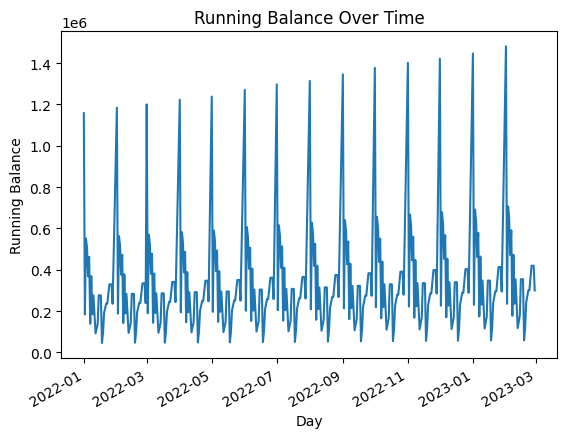

In [20]:
# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Group by 'timestamp' and calculate the sum of 'runningBalance'
running_balance_by_day = df.groupby(['timestamp'])['running_balance'].sum()

# Plot the time series
running_balance_by_day.plot(kind='line')
plt.title('Running Balance Over Time')
plt.xlabel('Day')
plt.ylabel('Running Balance')
plt.show()


<ipython-input-21-bfe2b504d47a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
<ipython-input-21-bfe2b504d47a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expenses['amount'] = df_expenses['amount'].abs()
<ipython-input-21-bfe2b504d47a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

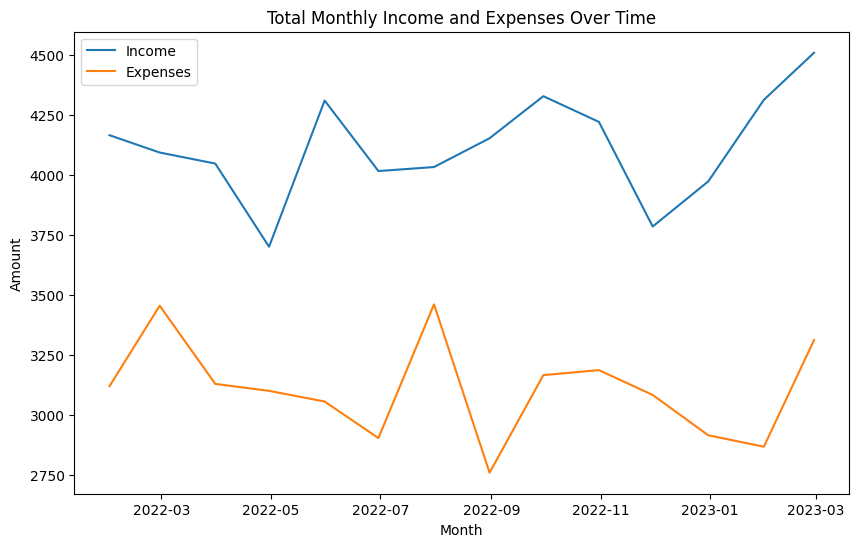

In [21]:
# ensure timestamp is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create a copy of the dataframe where the index is the timestamp
df_time_index = df.set_index('timestamp')

# Separate income and expenses transactions
df_expenses = df_time_index[df_time_index['amount'] < 0]
df_income = df_time_index[df_time_index['amount'] > 0]

# Make amounts positive for ease of interpretation
df_expenses['amount'] = df_expenses['amount'].abs()
df_income['amount'] = df_income['amount'].abs()

# Resample to get total monthly income and expenses
monthly_expenses = df_expenses['amount'].resample('M').sum()
monthly_income = df_income['amount'].resample('M').sum()

# Plot total monthly income and expenses over time
plt.figure(figsize=(10, 6))
plt.plot(monthly_income.index, monthly_income.values, label='Income')
plt.plot(monthly_expenses.index, monthly_expenses.values, label='Expenses')
plt.title('Total Monthly Income and Expenses Over Time')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend()
plt.show()


<ipython-input-22-8eaea89d2423>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])


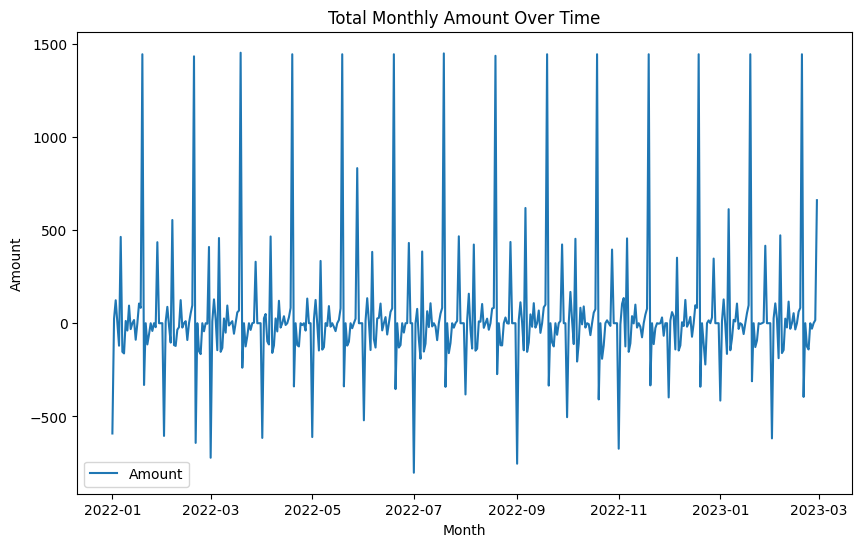

In [22]:
# ensure timestamp is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create a copy of the dataframe where the index is the timestamp
df_time_index = df.set_index('timestamp')

# Resample to get total monthly 'amount'
monthly_amount = df_time_index['amount'].resample('D').sum()

# Plot total monthly 'amount' over time
plt.figure(figsize=(10, 6))
plt.plot(monthly_amount.index, monthly_amount.values, label='Amount')
plt.title('Total Monthly Amount Over Time')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


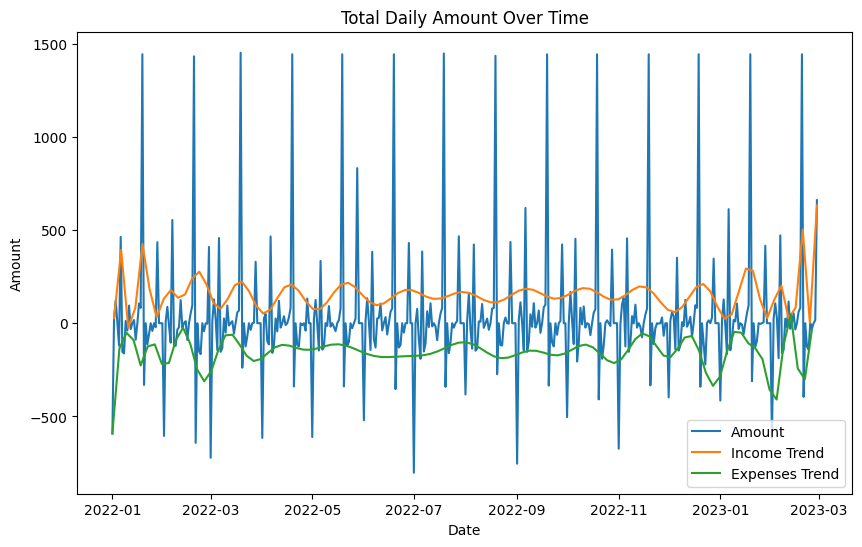

In [23]:
# Create a copy of the dataframe where the index is the timestamp
df_time_index = df.set_index('timestamp')

# Resample to get total daily 'amount'
daily_amount = df_time_index['amount'].resample('D').sum()

# Separate positive and negative amounts
positive_amounts = daily_amount[daily_amount >= 0]
negative_amounts = daily_amount[daily_amount < 0]

# Convert index to integer for polynomial fit
x_positive = np.array(positive_amounts.index, dtype='datetime64[D]').astype(int)
x_negative = np.array(negative_amounts.index, dtype='datetime64[D]').astype(int)

# Fit a polynomial of degree 1 (i.e., a line) to the data
poly_positive = Polynomial.fit(x_positive, positive_amounts, 50)
poly_negative = Polynomial.fit(x_negative, negative_amounts, 50)

# Plot total daily amount and the trend lines over time
plt.figure(figsize=(10, 6))
plt.plot(daily_amount.index, daily_amount.values, label='Amount')
plt.plot(*poly_positive.linspace(), label='Income Trend')
plt.plot(*poly_negative.linspace(), label='Expenses Trend')
plt.title('Total Daily Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()


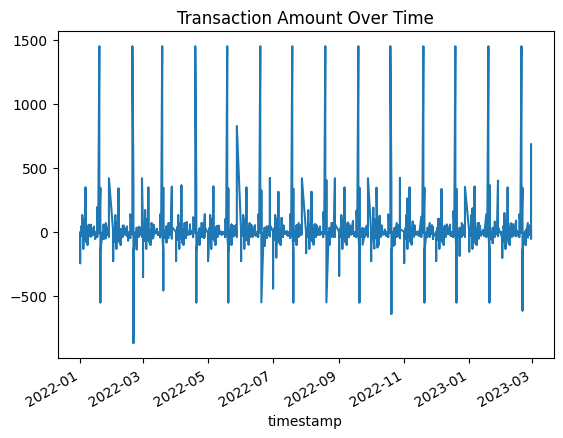

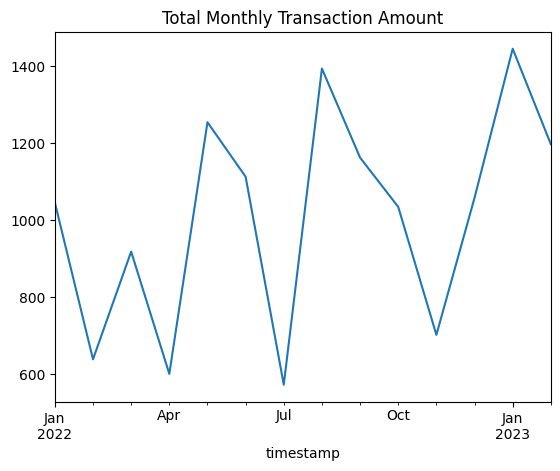

In [24]:
# Trends and Seasonality:
df.set_index('timestamp')['amount'].plot()
plt.title('Transaction Amount Over Time')
plt.show()

# Resample into monthly timeframe
df.resample('M', on='timestamp')['amount'].sum().plot()
plt.title('Total Monthly Transaction Amount')
plt.show()


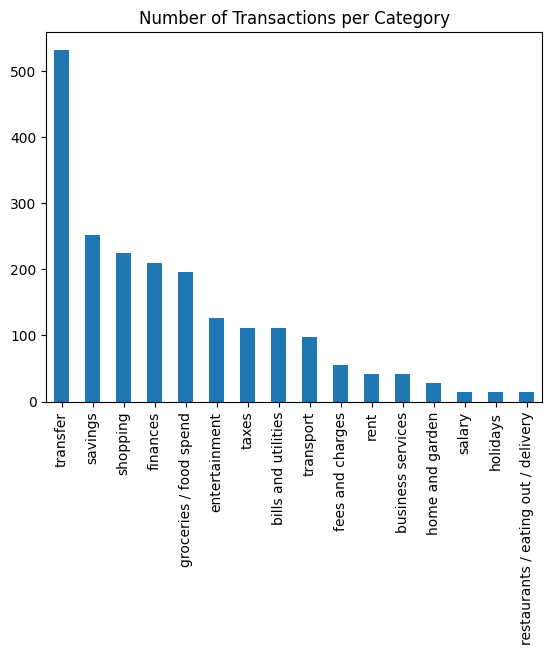

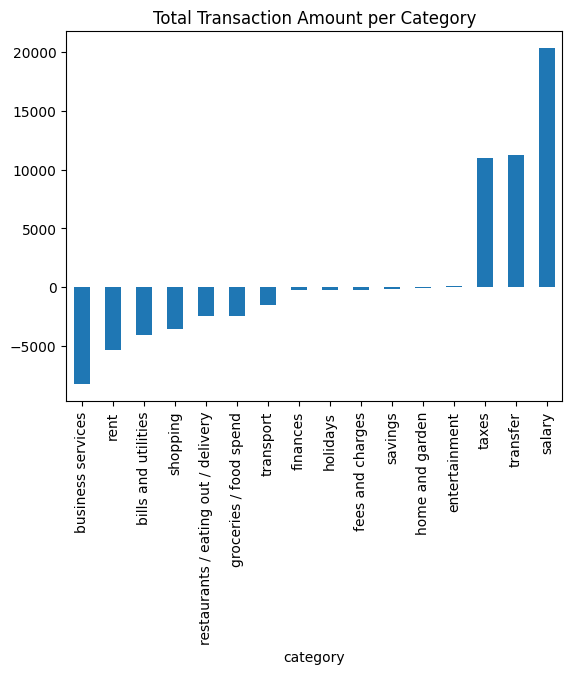

In [25]:
# transaction category
# Frequency of transactions per category
df['category'].value_counts().plot(kind='bar')
plt.title('Number of Transactions per Category')
plt.show()

# Total transaction amount per category
df.groupby('category')['amount'].sum().sort_values().plot(kind='bar')
plt.title('Total Transaction Amount per Category')
plt.show()


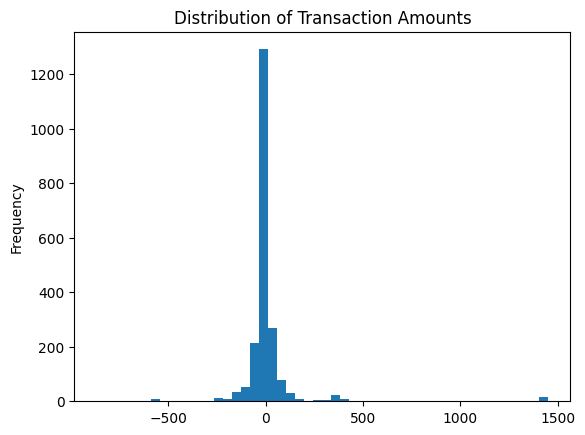

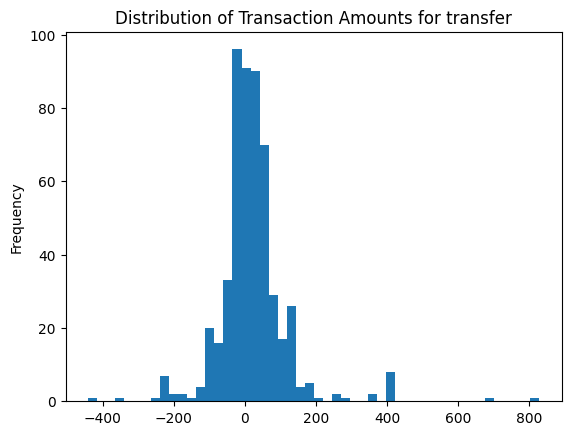

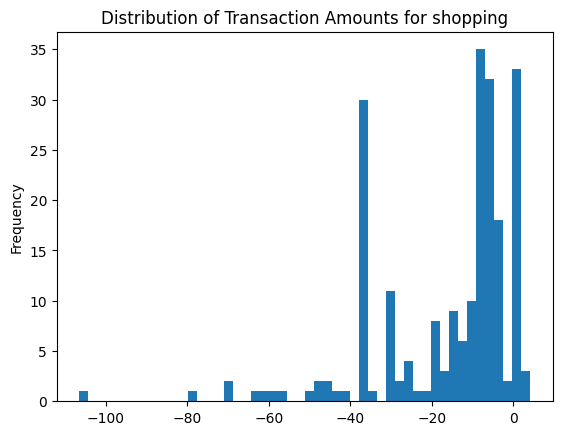

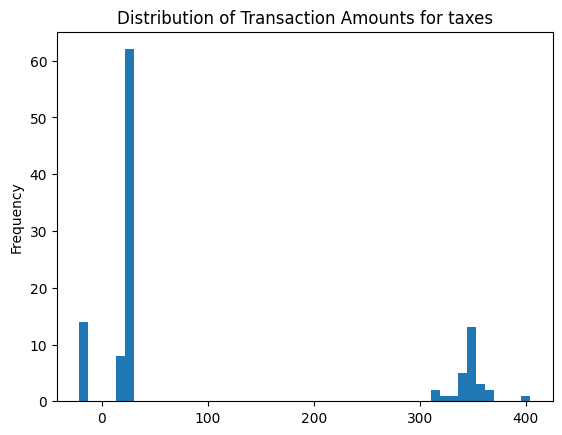

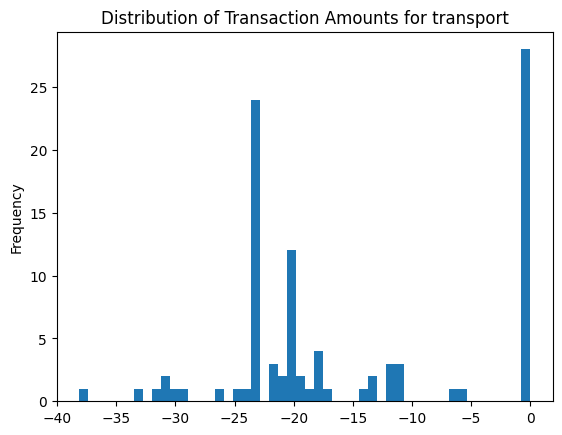

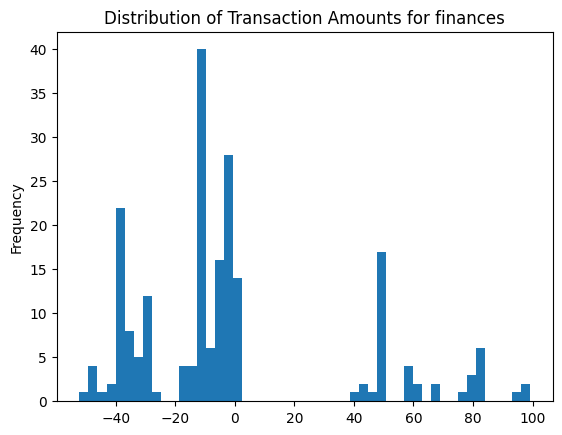

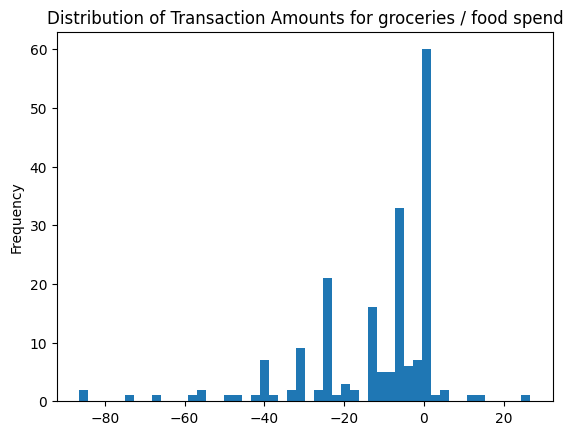

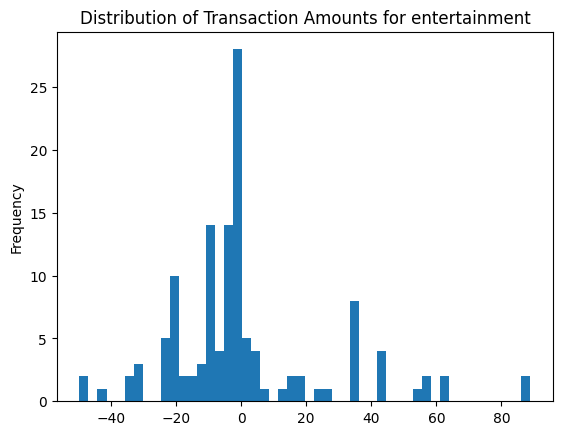

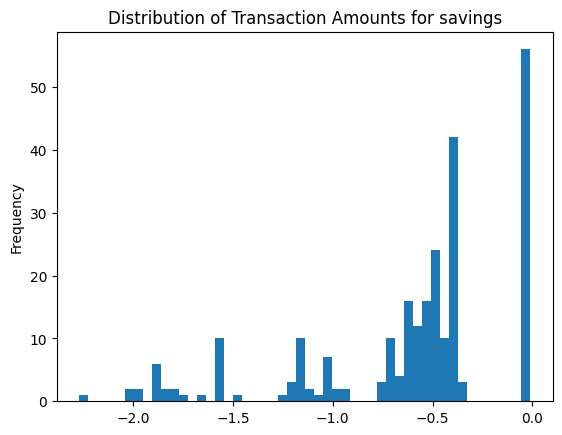

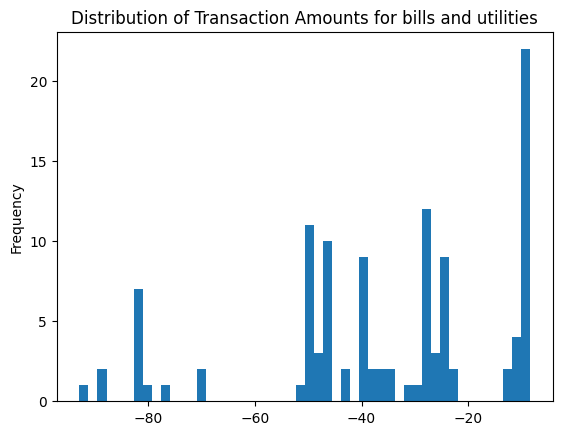

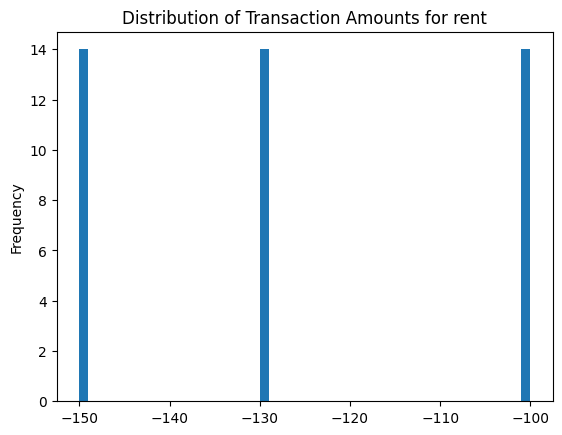

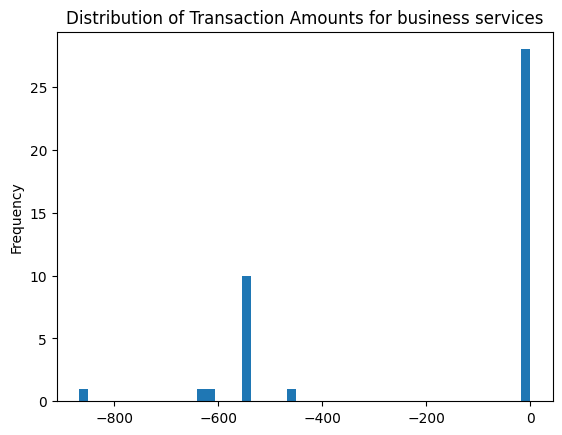

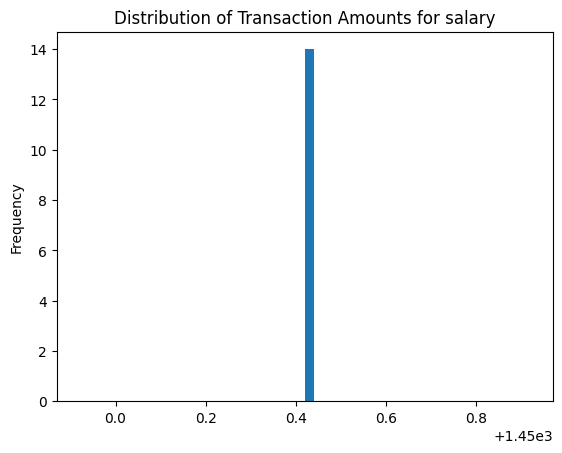

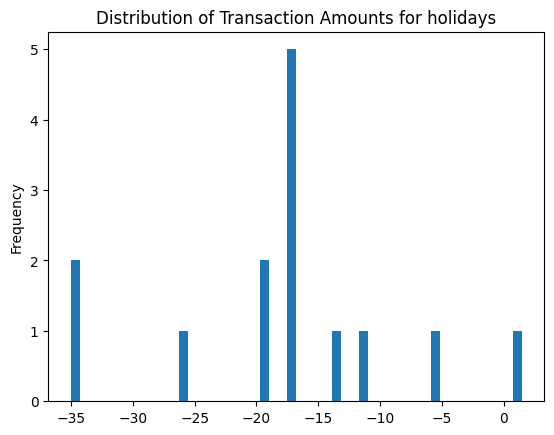

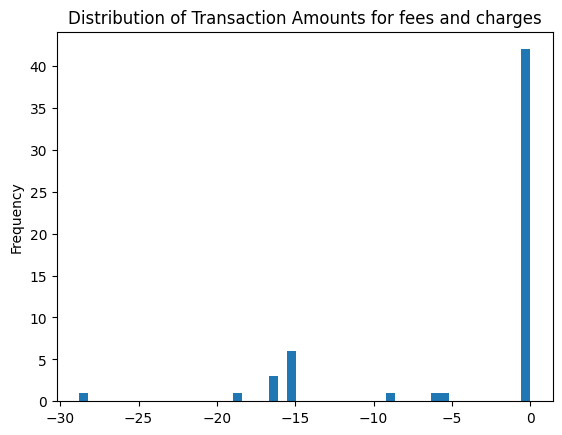

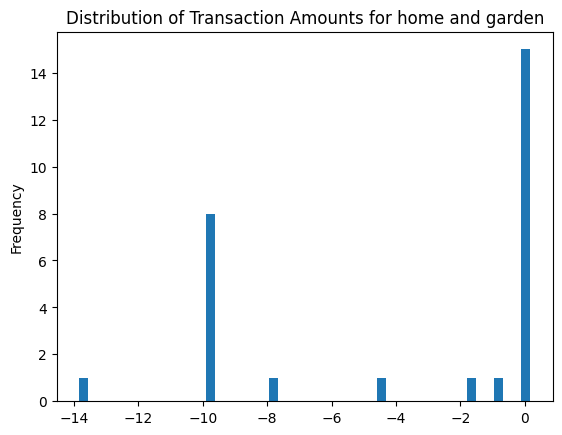

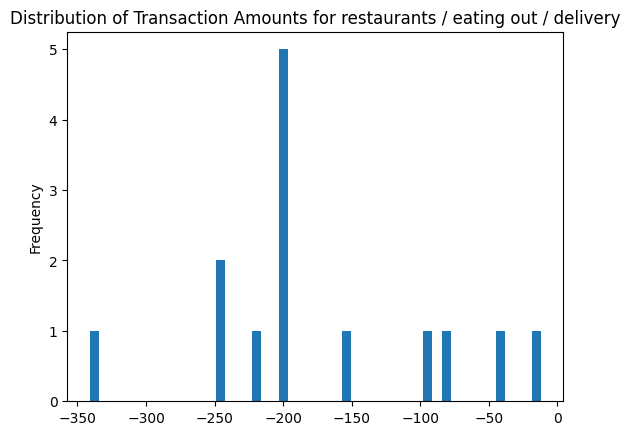

In [26]:
# Distribution of Transaction Amounts
df['amount'].plot(kind='hist', bins=50)
plt.title('Distribution of Transaction Amounts')
plt.show()

# If you want to see distribution for each category
for category in df['category'].unique():
    df[df['category'] == category]['amount'].plot(kind='hist', bins=50)
    plt.title(f'Distribution of Transaction Amounts for {category}')
    plt.show()


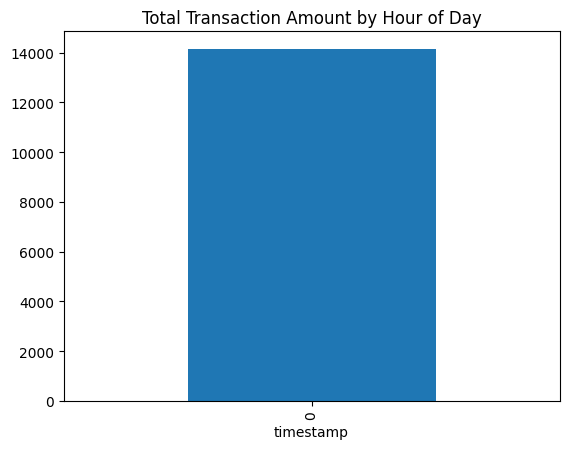

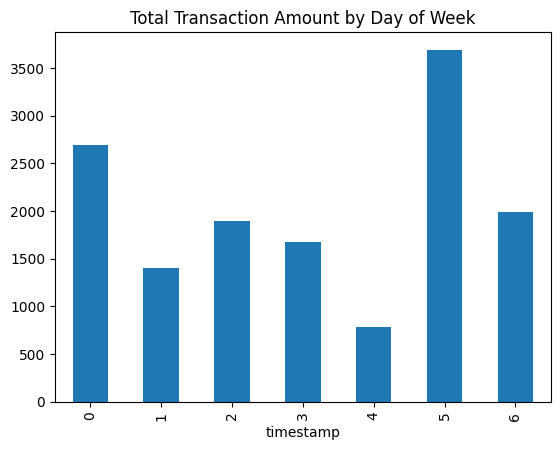

In [27]:
# Temporal Distribution:
# Transaction amount by hour of day
df.groupby(df['timestamp'].dt.hour)['amount'].sum().plot(kind='bar')
plt.title('Total Transaction Amount by Hour of Day')
plt.show()

# Transaction amount by day of week (0 = Monday, 6 = Sunday)
df.groupby(df['timestamp'].dt.dayofweek)['amount'].sum().plot(kind='bar')
plt.title('Total Transaction Amount by Day of Week')
plt.show()


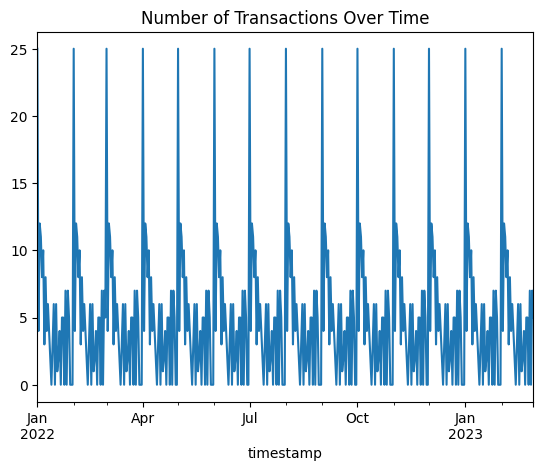

In [28]:
# transaction counts
df.set_index('timestamp').resample('D').size().plot()
plt.title('Number of Transactions Over Time')
plt.show()


In [29]:
# Create 'day_of_week' and 'month_of_year' columns
df['day_of_week'] = df['timestamp'].dt.day_name()
df['month_of_year'] = df['timestamp'].dt.month_name()


<ipython-input-29-ed8f14a9b88b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df['timestamp'].dt.day_name()
<ipython-input-29-ed8f14a9b88b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_of_year'] = df['timestamp'].dt.month_name()


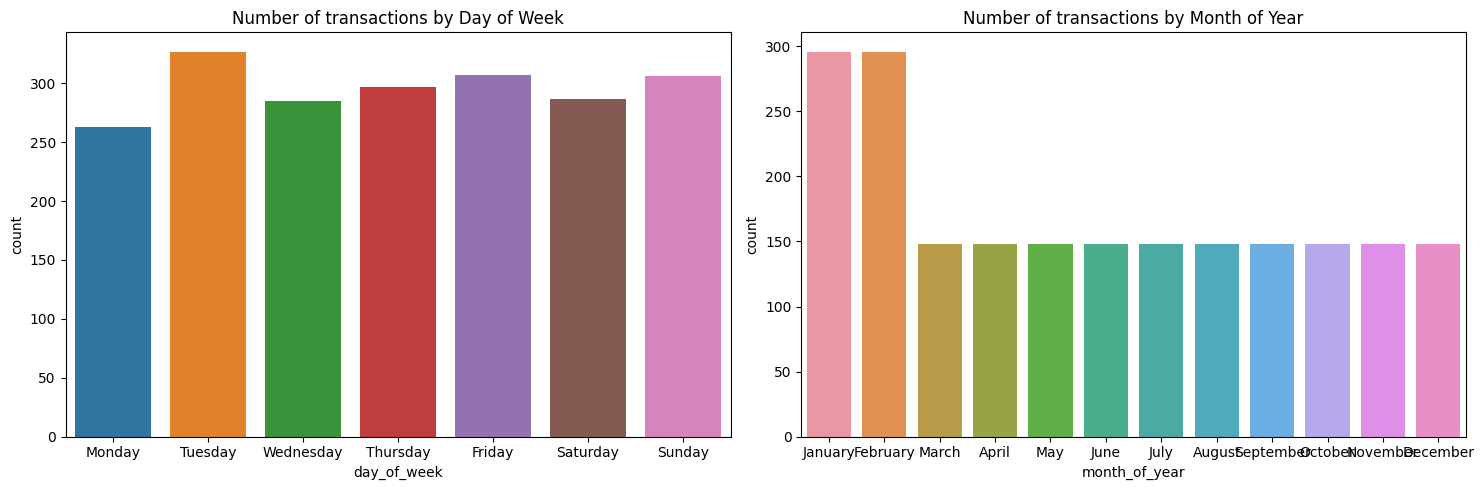

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Transactions per day of the week
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.countplot(data=df, x='day_of_week', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of transactions by Day of Week')

# Transactions per month of the year
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.countplot(data=df, x='month_of_year', order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Number of transactions by Month of Year')

plt.tight_layout()  # To prevent overlap of subplot titles and labels
plt.show()


In [31]:
df

,timestamp,description,transaction_type,transaction_category,merchant_name,amount,currency,running_balance,category,month_year,day_of_week,month_of_year
402,2023-02-28 00:00:00+00:00,TSB CLEVELEYS,CREDIT,CASH,NaN,684.85,GBP,59987.22,transfer,2023-02,Tuesday,February
403,2023-02-28 00:00:00+00:00,AMAZON INT'L,DEBIT,PURCHASE,Amazon,-36.59,GBP,60023.81,shopping,2023-02,Tuesday,February
404,2023-02-28 00:00:00+00:00,RETURNED DD,CREDIT,CREDIT,NaN,40.00,GBP,59983.81,transfer,2023-02,Tuesday,February
405,2023-02-28 00:00:00+00:00,MR JOHN SMITH,DEBIT,TRANSFER,NaN,-51.56,GBP,60035.37,transfer,2023-02,Tuesday,February
406,2023-02-28 00:00:00+00:00,WORKING TAX CREDIT,CREDIT,CREDIT,NaN,22.99,GBP,60012.38,taxes,2023-02,Tuesday,February
...,...,...,...,...,...,...,...,...,...,...,...,...
2469,2022-01-01 00:00:00+00:00,NUDE FINANCE,DEBIT,PURCHASE,Nude Finance,-10.00,GBP,46488.69,business services,2022-01,Saturday,January
2470,2022-01-01 00:00:00+00:00,E.ON NEXT,DEBIT,PURCHASE,E.on Next,-9.47,GBP,46498.16,bills and utilities,2022-01,Saturday,January
2471,2022-01-01 00:00:00+00:00,L&G INSURANCE,DEBIT,PURCHASE,NaN,-10.00,GBP,46508.16,finances,2022-01,Saturday,January
2472,2022-01-01 00:00:00+00:00,HALIFAX,DEBIT,PURCHASE,Halifax,-10.00,GBP,46518.16,finances,2022-01,Saturday,January


In [32]:
df_copy = df.copy()

# Convert 'timestamp' to datetime if it's not
df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])

# Create 'day_of_week' and 'month_of_year' columns
df_copy['day_of_week'] = df_copy['timestamp'].dt.day_name()
df_copy['month_of_year'] = df_copy['timestamp'].dt.month_name()

# Separate income and expense transactions
df_copy.loc[df_copy['amount'] > 0, 'income'] = df_copy['amount']
df_copy.loc[df_copy['amount'] < 0, 'expenses'] = df_copy['amount']

# Fill NaN values with 0
df_copy['income'].fillna(0, inplace=True)
df_copy['expenses'].fillna(0, inplace=True)


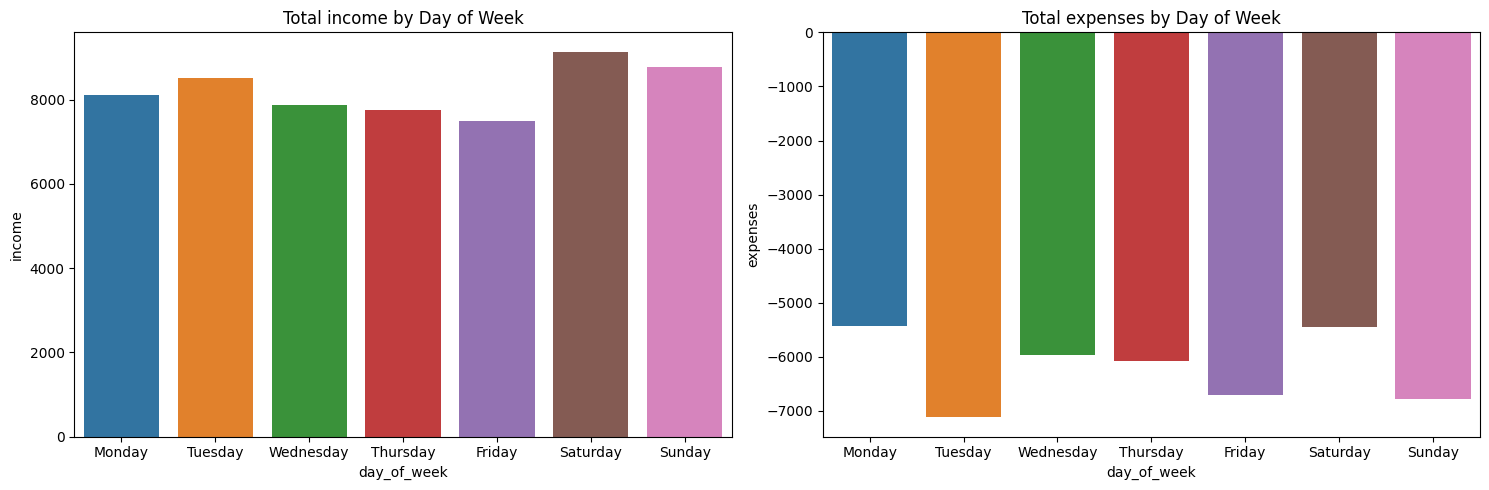

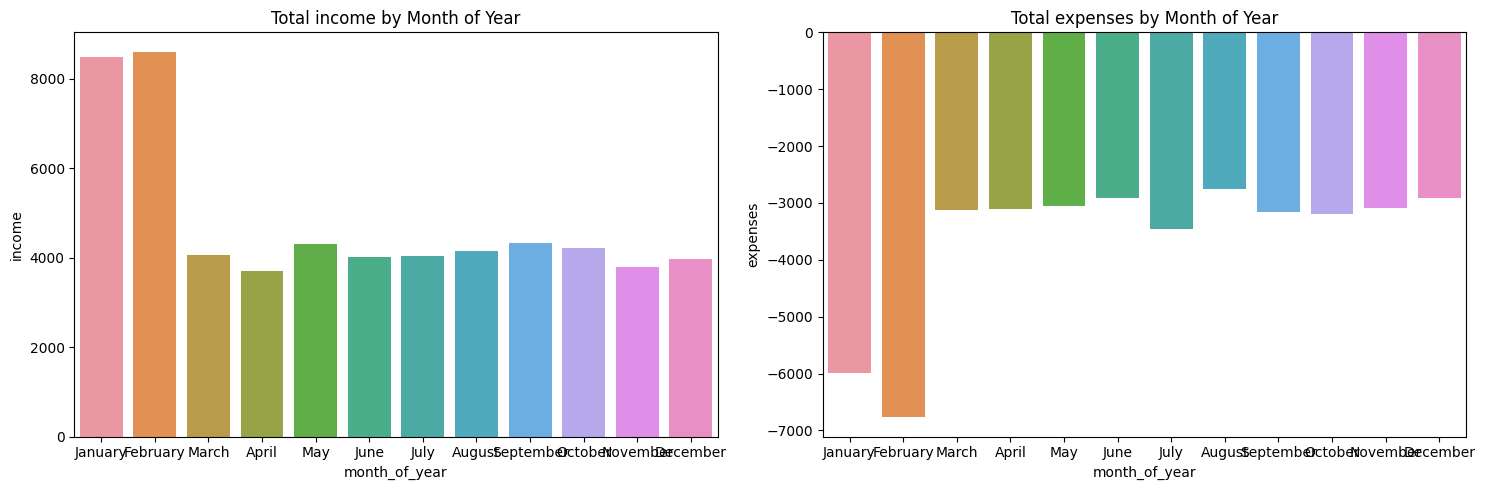

In [33]:
# Separate income and expense transactions
df_copy.loc[df_copy['amount'] > 0, 'income'] = df_copy['amount']
df_copy.loc[df_copy['amount'] < 0, 'expenses'] = df_copy['amount']

# Total income and expenses per day of the week
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.barplot(data=df_copy, x='day_of_week', y='income', estimator=sum, errorbar=None, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Total income by Day of Week')
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.barplot(data=df_copy, x='day_of_week', y='expenses', estimator=sum, errorbar=None, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Total expenses by Day of Week')
plt.tight_layout()
plt.show()

# Total income and expenses per month of the year
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.barplot(data=df_copy, x='month_of_year', y='income', estimator=sum, errorbar=None, order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Total income by Month of Year')
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.barplot(data=df_copy, x='month_of_year', y='expenses', estimator=sum, errorbar=None, order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Total expenses by Month of Year')
plt.tight_layout()
plt.show()


<ipython-input-34-33d8a451eb9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_of_year'] = df['timestamp'].dt.month_name()


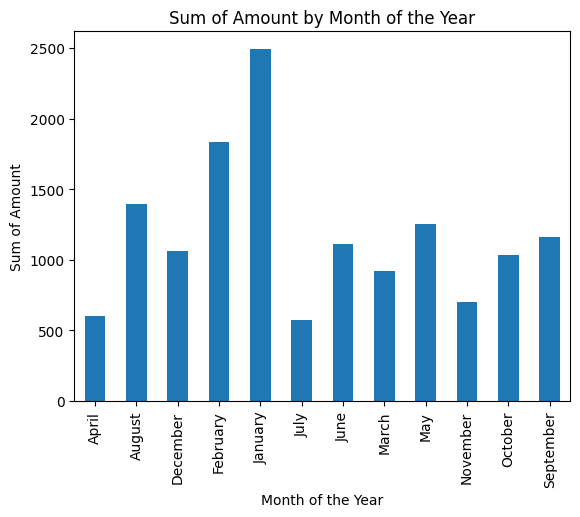

In [34]:
# Create a new column for the month of the year
df['month_of_year'] = df['timestamp'].dt.month_name()

# Group by 'month_of_year' and calculate the sum of 'amount'
monthly_amount = df.groupby(['month_of_year'])['amount'].sum()

# Plot the sum of 'amount' for each month of the year
monthly_amount.plot(kind='bar')
plt.title('Sum of Amount by Month of the Year')
plt.xlabel('Month of the Year')
plt.ylabel('Sum of Amount')
plt.show()


# Autocorrelation

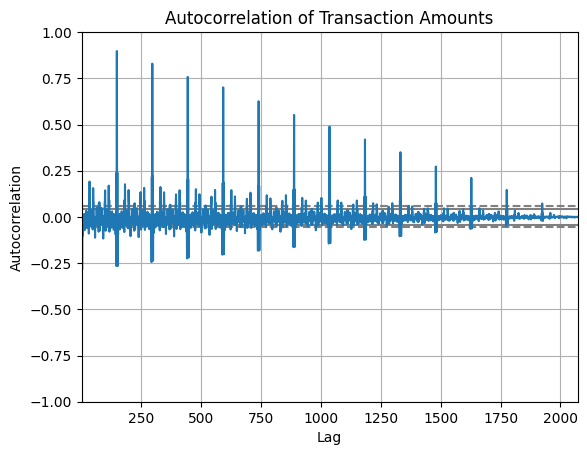

In [35]:
# autocorrelation
autocorrelation_plot(df.set_index('timestamp')['amount'])
plt.title('Autocorrelation of Transaction Amounts')
plt.show()


In [36]:
# calculate autocorrelation using statsmodels
df.set_index('timestamp', inplace=True)
autocorr_values = acf(df['amount'])

# create a scatter plot
fig = go.Figure(data=go.Scatter(
    x=list(range(len(autocorr_values))),
    y=autocorr_values,
    mode='lines+markers'
))

# add a horizontal line
fig.add_trace(go.Scatter(
    x=[0, len(autocorr_values)],
    y=[0, 0],
    mode='lines',
    name='Zero Line',
    line=dict(color='black', dash='dash')
))

# update layout
fig.update_layout(
    title="Autocorrelation of Transaction Amounts",
    xaxis_title="Lag",
    yaxis_title="Autocorrelation",
)

fig.show()


In [37]:
# Compute autocorrelation
autocorr_values = acf(df['amount'], nlags=40)

# Create x values (lags)
lags = list(range(len(autocorr_values)))

# Create Plotly figure
fig = go.Figure(data=go.Scatter(x=lags, y=autocorr_values, mode='lines+markers'))

# Set layout properties
fig.update_layout(title='Autocorrelation of Transaction Amounts',
                   xaxis_title='Lag',
                   yaxis_title='Autocorrelation',
                   autosize=False,
                   width=800,
                   height=500,
                   )

# Show plot
fig.show()


In [38]:
# Compute autocorrelation
autocorr_values = acf(df['amount'], nlags=40)

# Create x values (lags)
lags = list(range(len(autocorr_values)))

# Convert the lists into a DataFrame
autocorr_df = pd.DataFrame({
    'Lag': lags,
    'Autocorrelation': autocorr_values
})

print(autocorr_df)


    Lag  Autocorrelation
0     0         1.000000
1     1        -0.020351
2     2         0.258425
3     3        -0.285316
4     4        -0.006560
5     5        -0.103030
6     6        -0.023858
7     7        -0.028076
8     8        -0.036609
9     9        -0.023148
10   10         0.010618
11   11        -0.020664
12   12         0.016055
13   13        -0.071681
14   14         0.015926
15   15        -0.019200
16   16        -0.005099
17   17        -0.006442
18   18        -0.000748
19   19        -0.002347
20   20         0.033213
21   21        -0.011884
22   22        -0.016168
23   23        -0.059615
24   24        -0.007730
25   25         0.001039
26   26         0.025025
27   27        -0.028678
28   28        -0.000981
29   29        -0.038088
30   30         0.028376
31   31        -0.089990
32   32         0.097354
33   33        -0.007950
34   34         0.191291
35   35        -0.021167
36   36        -0.015228
37   37        -0.019443
38   38        -0.020665


In [39]:
# Loop through each unique category
for category in df['category'].unique():
    # Select only the rows of the current category
    category_df = df[df['category'] == category]

    # Compute autocorrelation
    autocorr_values = acf(category_df['amount'], nlags=40)

    # Create x values (lags)
    lags = list(range(len(autocorr_values)))

    # Create Plotly figure
    fig = go.Figure(data=go.Scatter(x=lags, y=autocorr_values, mode='lines+markers'))

    # Set layout properties
    fig.update_layout(title=f'Autocorrelation of {category} Transaction Amounts',
                       xaxis_title='Lag',
                       yaxis_title='Autocorrelation',
                       autosize=False,
                       width=800,
                       height=500,
                       )

    # Show plot
    fig.show()


In [40]:
# Prepare an empty dictionary to hold dataframes
autocorr_dfs = {}

# Loop through each unique category
for category in df['category'].unique():
    # Select only the rows of the current category
    category_df = df[df['category'] == category]

    # Compute autocorrelation
    autocorr_values = acf(category_df['amount'], nlags=40)

    # Create a dataframe
    autocorr_df = pd.DataFrame({
        'Lag': list(range(len(autocorr_values))),
        'Autocorrelation': autocorr_values
    })

    # Add the dataframe to the dictionary
    autocorr_dfs[category] = autocorr_df

    # Print a message
    print(f'Autocorrelation dataframe for {category} created.')


Autocorrelation dataframe for transfer created.
Autocorrelation dataframe for shopping created.
Autocorrelation dataframe for taxes created.
Autocorrelation dataframe for transport created.
Autocorrelation dataframe for finances created.
Autocorrelation dataframe for groceries / food spend created.
Autocorrelation dataframe for entertainment created.
Autocorrelation dataframe for savings created.
Autocorrelation dataframe for bills and utilities created.
Autocorrelation dataframe for rent created.
Autocorrelation dataframe for business services created.
Autocorrelation dataframe for salary created.
Autocorrelation dataframe for holidays created.
Autocorrelation dataframe for fees and charges created.
Autocorrelation dataframe for home and garden created.
Autocorrelation dataframe for restaurants / eating out / delivery created.


In [41]:
autocorr_dfs

{'transfer':     Lag  Autocorrelation
 0     0         1.000000
 1     1        -0.040673
 2     2        -0.305125
 3     3        -0.095818
 4     4         0.034900
 5     5         0.036682
 6     6         0.028468
 7     7        -0.049361
 8     8        -0.124214
 9     9         0.021189
 10   10        -0.146565
 11   11         0.333235
 12   12         0.169302
 13   13        -0.218707
 14   14        -0.170937
 15   15         0.093852
 16   16         0.070328
 17   17         0.080890
 18   18         0.057560
 19   19        -0.360822
 20   20         0.047727
 21   21         0.069168
 22   22         0.094012
 23   23         0.101815
 24   24        -0.168179
 25   25        -0.224330
 26   26         0.167168
 27   27         0.307655
 28   28        -0.135166
 29   29         0.055254
 30   30        -0.127001
 31   31        -0.041947
 32   32         0.010709
 33   33         0.041129
 34   34         0.026845
 35   35        -0.087048
 36   36        -0.314630


In [42]:
# First create a copy of your original dataframe to avoid modifying original data
df_diff = df.copy()

# Loop over each category
for category in df_diff['category'].unique():
    # Select data for the current category
    category_df = df_diff[df_diff['category'] == category]['amount']

    # Perform Augmented Dickey-Fuller test
    result = adfuller(category_df)

    # If the series is non-stationary (p-value > 0.05), difference it
    if result[1] > 0.05:
        df_diff.loc[df_diff['category'] == category, 'amount'] = category_df.diff()

# Drop the first row of each category because differencing creates NaN values
df_diff.dropna(subset=['amount'], inplace=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning:

divide by zero encountered in log



In [43]:
# Apply the Augmented Dickey-Fuller test to each category's amount
for category in df_diff['category'].unique():
    category_df = df_diff[df_diff['category'] == category]
    result = adfuller(category_df['amount'])
    print(f'ADF Statistic for category {category}: {result[0]}')
    print(f'p-value: {result[1]}')


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning:

divide by zero encountered in log



ADF Statistic for category transfer: -5.823036111608225
p-value: 4.140115215068327e-07
ADF Statistic for category shopping: -3.168347355004846
p-value: 0.02189153375345611
ADF Statistic for category taxes: -3.201358065791653
p-value: 0.01990620349544639
ADF Statistic for category transport: -4.287656811227343
p-value: 0.00046659042054003445
ADF Statistic for category entertainment: -3.232946575495059
p-value: 0.018155073338082386
ADF Statistic for category savings: -29.928808345891817
p-value: 0.0
ADF Statistic for category finances: -33.22502086931496
p-value: 0.0
ADF Statistic for category rent: -22953070830.834717
p-value: 0.0
ADF Statistic for category salary: nan
p-value: nan
ADF Statistic for category groceries / food spend: -7.92600807217467
p-value: 3.6172991735042994e-12
ADF Statistic for category bills and utilities: -70.16921087444992
p-value: 0.0
ADF Statistic for category home and garden: -3.0260159661997696
p-value: 0.0325352339119891
ADF Statistic for category business s

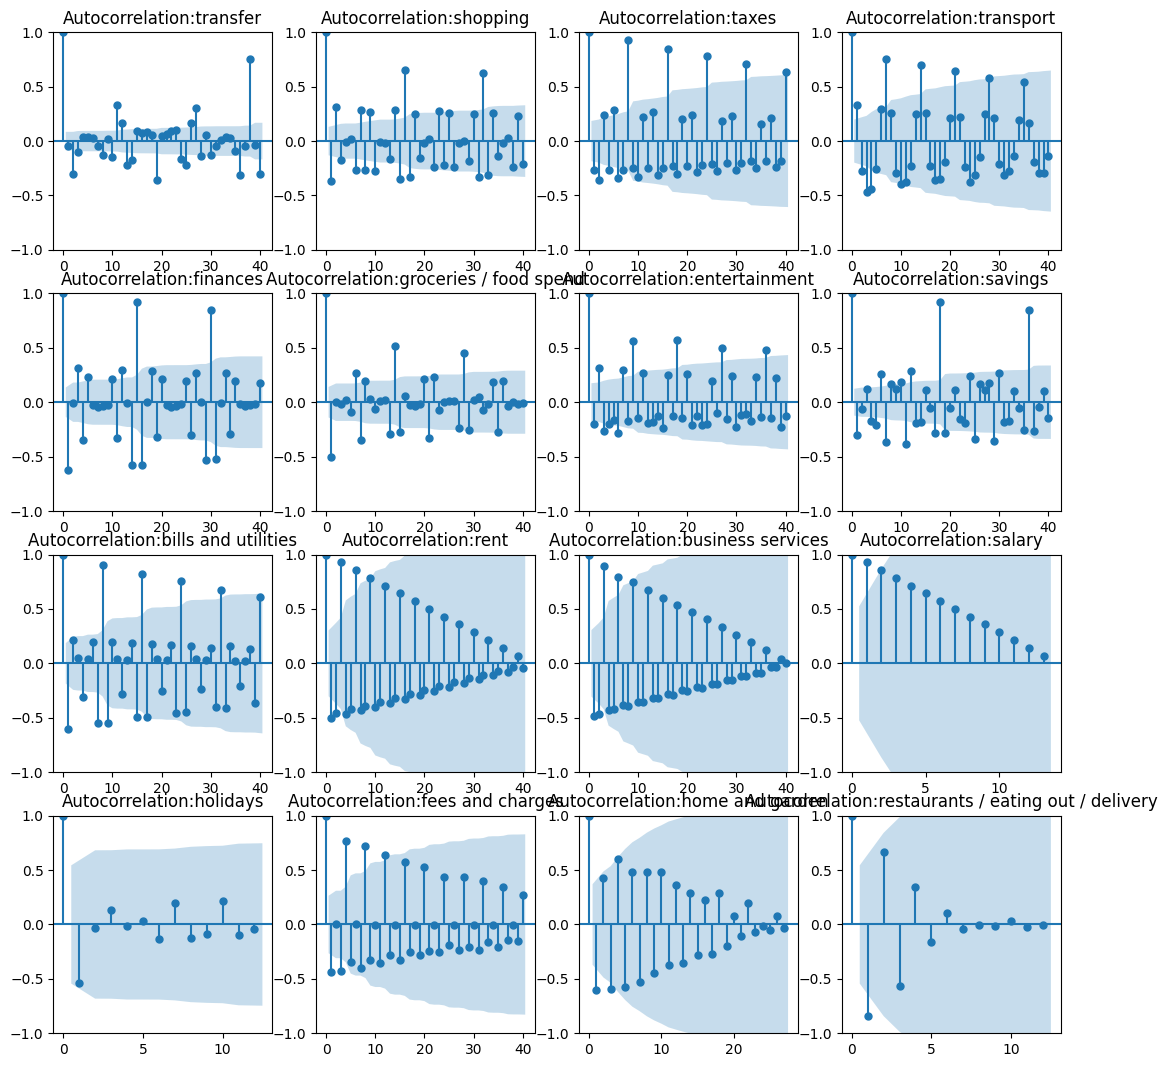

In [44]:
fig, axs = plt.subplots(4, 4, figsize=(13, 13))  # Creates a 4x4 grid of plots
axs = axs.flatten()  # Flattens the 4x4 grid to a 1D array to easily iterate

# Ensure 'category' is of type categorical to retain order when using unique()
df_diff['category'] = df_diff['category'].astype('category')

for i, category in enumerate(df['category'].unique()):
    category_df = df_diff[df_diff['category'] == category]

    if len(category_df) > 40:  # Ensure there are more than 40 data points
        plot_acf(category_df['amount'], lags=40, ax=axs[i], title=f'Autocorrelation:{category}')
    else:
        # Handle cases where there are not enough data points
        # For example, plot with a reduced number of lags
        plot_acf(category_df['amount'], lags=len(category_df)-1, ax=axs[i], title=f'Autocorrelation:{category}')
